In [3]:
import stellargraph as sg

In [2]:
import matplotlib.pyplot as plt
import import_ipynb
from sklearn.manifold import TSNE

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [4]:
import Recipe_Graph

importing Jupyter notebook from Recipe_Graph.ipynb


In [9]:
df = pd.read_csv('Input_receipe.csv', index_col = [0])

In [10]:
df.head()

,Source,Target,Weight
0,black olives,garlic,55
1,black olives,romaine lettuce,7
2,black olives,purple onion,34
3,black olives,grape tomatoes,4
4,black olives,feta cheese crumbles,12


In [11]:
df.shape

(729862, 3)

In [18]:
df_sel = df[df['Source'] == 'garlic']

In [51]:
df_sel.shape

(3227, 3)

In [65]:
df_sel.head()

,Source,Target,Weight
6,garlic,black olives,55
7,garlic,romaine lettuce,48
8,garlic,purple onion,399
9,garlic,grape tomatoes,49
10,garlic,feta cheese crumbles,58


In [19]:
GR = nx.from_pandas_edgelist(df_sel,'Source', 'Target',["Weight"])

## Convert the Graph into a StellarGraph for Machine Learning

In [22]:
GS = StellarGraph.from_networkx(GR)

In [23]:
print(GS.info())

StellarGraph: Undirected multigraph
 Nodes: 3214, Edges: 3213

 Node types:
  default: [3214]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [3213]
        Weights: all 1 (default)
        Features: none


In [24]:
subjects = GS.nodes()
#subjects = pd.core.series.Series(subjects)

## The Node2Vec algorithm

The number of walks to take per node, the length of each walk

In [33]:
walk_number = 100
walk_length = 5

Create the biased random walker to perform context node sampling, with the specified parameters.

In [34]:
walker = BiasedRandomWalk(
    GS,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)

Create the UnsupervisedSampler instance with the biased random walker.

In [35]:
unsupervised_samples = UnsupervisedSampler(GS, nodes=list(GS.nodes()), walker=walker)

Set the batch size and the number of epochs

In [36]:
batch_size = 50
epochs = 2

Define an attri2vec training generator, which generates a batch of (index of target node, index of context node, label of node pair) pairs per iteration

In [37]:
generator = Node2VecLinkGenerator(GS, batch_size)

Build the Node2Vec model, with the dimension of learned node representations set to 128

In [38]:
emb_size = 12
node2vec = Node2Vec(emb_size, generator=generator)

In [39]:
x_inp, x_out = node2vec.in_out_tensors()

Use the link_classification function to generate the prediction, with the 'dot' edge embedding generation method and the 'sigmoid' activation, which actually performs the dot product of the input embedding of the target node and the output embedding of the context node followed by a sigmoid activation.

In [40]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


Stack the Node2Vec encoder and prediction layer into a Keras model. Our generator will produce batches of positive and negative context pairs as inputs to the model. Minimizing the binary crossentropy between the outputs and the provided ground truth is much like a regular binary classification task.

In [41]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

Train the model.

In [42]:
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/2
51424/51424 [==============================] - 40s 768us/step - loss: 0.6624 - binary_accuracy: 0.5932
Epoch 2/2
51424/51424 [==============================] - 39s 762us/step - loss: 0.6128 - binary_accuracy: 0.6889


In [43]:
#sg.utils.plot_history(history)


## Visualise Node Embeddings

Build the node based model for predicting node representations from node ids and the learned parameters. Below a Keras model is constructed, with x_inp[0] as input and x_out[0] as output. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [44]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

Get the node embeddings from node ids.

In [45]:
node_gen = Node2VecNodeGenerator(GS, batch_size).flow(subjects)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

65/65 [==============================] - 0s 2ms/step


In [64]:
len(node_embeddings[0])

12

Transform the embeddings to 2d space for visualisation.

In [52]:
len(node_embeddings)

3214

In [47]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [83]:
#node_embeddings_2d

In [114]:
import time
from sklearn.metrics.pairwise import cosine_similarity
emvec_dic = {}
start = time.time()
for i, ele1 in enumerate(node_embeddings_2d):
    for j, ele2 in enumerate(node_embeddings_2d):
         if i not in emvec_dic.keys():
            cos_sim = cosine_similarity([ele1], [ele2])
            #emvec_key = subjects[i]
            emvec_dic[subjects[i]] = cos_sim[0][0]
print(f'{time.time()-start} seconds')        

KeyboardInterrupt: 

In [ ]:
len(emvec_dic)

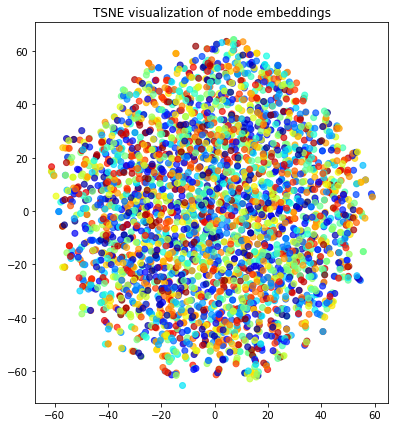

In [48]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()